# Part I: Simulate view of scene with perspective projection


- Using right-handed coordinates in this example
- E matrix is now E = TR (translation and rotation)

In [33]:
from google.colab import files
src = list(files.upload().values())[0]
open('helpers.py','wb').write(src)
import helpers

Saving helpers.py to helpers.py


In [0]:
import numpy as np
from helpers import projectPoints, transform_camera
from math import sin, cos, pi

# Define n random points in 1x1x1 cube centred at (0,0,2): 
# n = 20
# np.random.rand(n,3) - 0.5 + np.array([[0,0,2.0]])

p = np.array([[-0.20927748, -0.11965883,  2.48251993],
              [ 0.21500058,  0.46747312,  1.71699167],
              [ 0.13794113,  0.40710104,  2.36350066],
              [-0.1128809 , -0.45828591,  1.68682432],
              [ 0.32599931, -0.23867501,  1.73969982],
              [ 0.00346673, -0.09103035,  1.93506751],
              [ 0.2135272 ,  0.4950768 ,  2.45342722],
              [ 0.27466235, -0.22815187,  2.45607104],
              [-0.47839264,  0.32521683,  2.01613783],
              [-0.31948988,  0.24392884,  1.90082198],
              [-0.02237736, -0.18178899,  2.04393325],
              [-0.06247404,  0.2827452 ,  1.77494647],
              [-0.17425092,  0.20846771,  2.33165073],
              [ 0.16587802, -0.15696543,  2.3328076 ],
              [-0.12601242, -0.47337959,  1.63615567],
              [ 0.10880008, -0.0778482 ,  1.71674749],
              [ 0.41734205,  0.3595651 ,  1.83386047],
              [ 0.19256327,  0.37458334,  2.38535092],
              [-0.30877242, -0.0445262 ,  1.53243441],
              [-0.39356732,  0.03873827,  1.60475767]])

# Define camera parameters

f  = 1          # focal length
bu = bv = 1     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [0]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

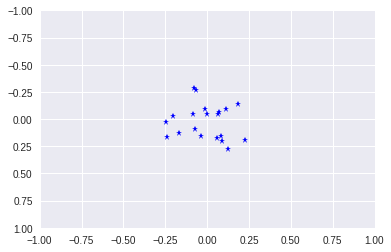

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [0]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transform_camera, p=fixed(p),
         x    = (-1.0,+1.0,0.01), y     = (-1.0,+1.0,0.01), z = (0.0,+2.0,0.01),
         roll = (-pi,+pi,0.01),   pitch = (-pi,+pi,0.01),   yaw = (-pi,+pi,0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

-------------------------
## Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
[0.  0.  1.1]


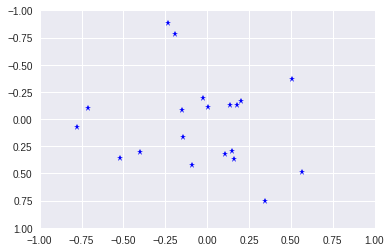

[[ 0.9605305   0.23339191 -0.15135845]
 [-0.19470917  0.95268912  0.23339191]
 [ 0.19866933 -0.19470917  0.9605305 ]]
[-0.2 -0.2  0.9]


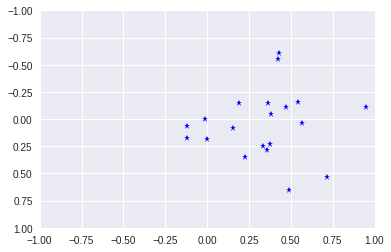

In [4]:
# Set up two camera positions

diff = -0.2
pts1 = transform_camera(p, x=0, y=0, z=1.1, roll=0, pitch=0, yaw=0)
pts2 = transform_camera(p, x=diff, y=diff, z=1.1+diff, roll=diff, pitch=diff, yaw=diff)

#### List pts1 and pts2:

In [5]:
pts1

array([[-0.15137393, -0.08655125],
       [ 0.34846594,  0.7576652 ],
       [ 0.10917377,  0.32220089],
       [-0.19235893, -0.7809593 ],
       [ 0.50961295, -0.3731047 ],
       [ 0.00415144, -0.10900957],
       [ 0.15776777,  0.36579492],
       [ 0.20254274, -0.16824478],
       [-0.52218413,  0.35498679],
       [-0.39895244,  0.30459808],
       [-0.02370651, -0.1925867 ],
       [-0.09256147,  0.418915  ],
       [-0.14147754,  0.16925879],
       [ 0.13455305, -0.12732354],
       [-0.23502954, -0.88291445],
       [ 0.17640944, -0.12622378],
       [ 0.56869401,  0.48996385],
       [ 0.14981377,  0.29142496],
       [-0.71403296, -0.10296637],
       [-0.77971538,  0.07674627]])

In [6]:
pts2

array([[ 1.88184068e-01, -1.51768713e-01],
       [ 4.91012526e-01,  6.53602568e-01],
       [ 3.32255707e-01,  2.48813369e-01],
       [ 4.25456179e-01, -5.55378579e-01],
       [ 9.46616275e-01, -1.08060676e-01],
       [ 3.84137863e-01, -5.08018822e-02],
       [ 3.58402058e-01,  2.86627835e-01],
       [ 5.44083746e-01, -1.54648270e-01],
       [-1.19604185e-01,  1.76318719e-01],
       [-2.19577455e-03,  1.84825641e-01],
       [ 3.66427687e-01, -1.52329528e-01],
       [ 2.27325697e-01,  3.45012567e-01],
       [ 1.56572076e-01,  7.93661781e-02],
       [ 4.71637980e-01, -1.14649397e-01],
       [ 4.28017386e-01, -6.11479055e-01],
       [ 5.67795254e-01,  3.83879015e-02],
       [ 7.16743605e-01,  5.30255301e-01],
       [ 3.73173182e-01,  2.32986922e-01],
       [-1.37924419e-02, -6.19769203e-04],
       [-1.21263908e-01,  5.91154261e-02]])

### Test sampling and scatterplot display functions

In [0]:
from helpers import generate_xyz_rpy

# Sample m states. Shape of S: (4, n_samples)
m = 100
S = np.concatenate((generate_xyz_rpy(m, -0.5, 0.5, -pi/4, pi/4), 1/m * np.ones((1,m))), axis = 0) 

print("Shape of initial S: " + str(S.shape))

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*S[:3,:], zdir='z', c= 'red')
ax1.set_xlim3d(-1, 1)
ax1.set_ylim3d(-1, 1)
ax1.set_zlim3d(-1, 1)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S[3:,:], c= 'red')
ax2.set_xlim3d(-pi/2, pi/2)
ax2.set_ylim3d(-pi/2, pi/2)
ax2.set_zlim3d(-pi/2, pi/2)
plt.show()

###  Run Particle Filter

In [16]:
from helpers import ParticleFilter, generate_xyz_rpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

iterations = 50

m = 2000
S = np.concatenate((generate_xyz_rpy(m, -0.5, 0.5, -pi/4, pi/4), 1/m * np.ones((1,m))), axis = 0) 

S_new = S
e = 0.00005
sigma_xyz = 0.1
sigma_rpy = 0.3

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma_xyz, sigma_rpy, pts1, pts2, epsilon = e)
    
    fig = plt.figure(figsize = (16,8))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(*S_new[:3,:], c= 'red')
    ax1.set_xlim3d(-2, 2)
    ax1.set_ylim3d(-2, 2)
    ax1.set_zlim3d(-2, 2)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(*S_new[3:,:], c= 'red')
    ax2.set_xlim3d(-pi, pi)
    ax2.set_ylim3d(-pi, pi)
    ax2.set_zlim3d(-pi, pi)
    
    plt.show()
    
    print(score_list)
    print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
    print("Sigma (xyz): %f  Sigma (rpy): %f" % (sigma_xyz, sigma_rpy))
    print("Epsilon: %f" % (e))
    print("Iteration: %d" % (i+1))
    
    # Decrease sigma over iterations
    if (i+1)%3 == 0:
        sigma_xyz *= 0.8
        sigma_rpy *= 0.8
    
    # Decrease epsilon over iterations
    if (i+1)%10 == 0:
        e *= 0.9
        
    # Increase sigma and epsilon if all solutions have too few matches (< 30%), usually when epsilon is small 
    # if max(score_list) < pts1.shape[0]*0.3:
    #     sigma_xyz *= 1.3
    #     sigma_rpy *= 1.3
        
    if score_list.count(pts1.shape[0]) > m/2: 
        break
    

### 4. Recover solution from Particle Filter

In [17]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
med   = np.median(S_new[:-1, :], axis = 1)
print("Average: " + str(ave))

# print("Median:  " + str(med))

Average: [-0.13788849 -0.54173564 -0.12909081 -0.39397572 -1.48067131 -1.29703163]


In [18]:
# Compare translation with ground truth by normalising both vectors
gt = np.array([diff, diff, diff])
t  = ave[:3]
print("Solution t:   " + str(t/np.linalg.norm(t)))
print("Ground truth: " + str(gt/np.linalg.norm(gt)))
print("Difference:   " + str(t/np.linalg.norm(t) - gt/np.linalg.norm(gt)))

Solution t:   [-0.24034089 -0.94425015 -0.22500646]
Ground truth: [-0.57735027 -0.57735027 -0.57735027]
Difference:   [ 0.33700938 -0.36689988  0.35234381]


In [19]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
r = ave[3:] % (2*pi)
gt = np.array([diff, diff, diff]) % (2*pi)

print("Solution r:   " + str(r))
print("Ground truth: " + str(gt))
print("Difference:   " + str(r - gt))

Solution r:   [5.88920958 4.802514   4.98615368]
Ground truth: [6.08318531 6.08318531 6.08318531]
Difference:   [-0.19397572 -1.28067131 -1.09703163]


In [20]:
# Construct E from solution t and r, check that (pts1)' T (pts2) = 0

from helpers import rpy2R

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

R = rpy2R(r[0], r[1], r[2])

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)

-0.020567147861719103
0.36197718763303177
0.1981551220229672
-0.24145843283425394
-0.12075038870241382
0.060897286276454306
0.2158749207726427
-0.016792910224790424
-0.018212233078516035
0.05937625161320144
0.00290550665180353
0.22157189966956456
0.08807501171619775
0.016635349836365602
-0.27936691898143096
0.10250474869120171
0.27928190142495873
0.1937513977460034
-0.04986474146602424
-0.09960842337419817


In [21]:
# Ground truth check of (pts1)' T (pts2) = 0 for comparison

t = np.array([diff, diff, diff, diff, diff, diff])

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

R = rpy2R(t[3], t[4], t[5])

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)

2.7755575615628914e-17
1.3877787807814457e-17
-1.3877787807814457e-17
5.551115123125783e-17
2.7755575615628914e-17
0.0
-6.938893903907228e-18
2.7755575615628914e-17
1.3877787807814457e-17
-2.0816681711721685e-17
1.3877787807814457e-17
0.0
-3.469446951953614e-18
-1.3877787807814457e-17
5.551115123125783e-17
2.7755575615628914e-17
6.938893903907228e-18
0.0
1.0408340855860843e-17
0.0
